# Applied Deep Learning with Python (2021-2022)
### DS-telecom-14

This project is led by Pierre PIOVESAN, Vincent JOSSE and Huan TROCHON in the group nicknamed «Shallow Mind».

https://github.com/baballev/shallowmind

## Introduction

For this project we decided to work on the long-term effects of COVID-19. As everyone knows, this disease can be lethal or leave severe lung damage. Identifying and studying these lesions can speed up the work of busy doctors and thus speed up patient management.

From a medical point of view, this project may be relevant because it helps doctors to make decisions. From an economic perspective, this project is also relevant since it allows a significant time saving for doctors which is an asset in this period of hospital crisis and shortage of qualified staff.

----

## 0. Requirements and data connection

In [ ]:
# These modules and libraries must be imported to properly run the notebook

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sklearn.model_selection    # for train_test_split
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from matplotlib.image import imread

Image.MAX_IMAGE_PIXELS = None

You can run the notebook on Colab with a copy of the folder in Drive. Otherwise you can run it locally.

Set the variable "**colab**" accordingly.

In [ ]:
colab = True

In [ ]:
if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  path_drive = "drive/MyDrive/Applied_DeepLearning"
else:
  path_drive = "set/your/path"

Mounted at /content/drive


Don't forget to unzip all your folders if not already done.

----

## 1. Data discovery and data cleaning 

We have found a dataset publicly available on Kaggle (https://www.kaggle.com/maedemaftouni/covid19-ct-scan-lesion-segmentation-dataset). Of course, as always, the data must be explored and cleaned in order to perfectly fit our goal.

The folder provided is composed of two sub-folders:
- frames 
- masks

1) The first sub-folder gathers CT-scans from lungs. These lungs may have physiological damage due to various diseases. Of course, the severity of the lesions varies greatly and can range from a very slight lesion to a very important lesion with very serious and dangerous lung damage.

The input data are grayscale 512*512 images, although they use 3 channels. Then we will use only 1 channel because only one channel is needed to encode a grayscale image. This will allow a parameter saving in our network and a more efficient training.

2) The second sub-folder gathers the corresponding segmentation of the lungs CT-scans. These data were annotated by specialized doctors who identified areas they considered to be affected by the disease. 

These data will be used as our output data. They will play the role of the ground truth for our segmentation. They are purely black and white 512*512 images with 1's in the affected areas and 0's in the normal areas.

Then, we can have a look at the raw data. We can see that some files in the dataset are **NOT** cases of corona virus.

torch.float32
torch.float32
torch.float32


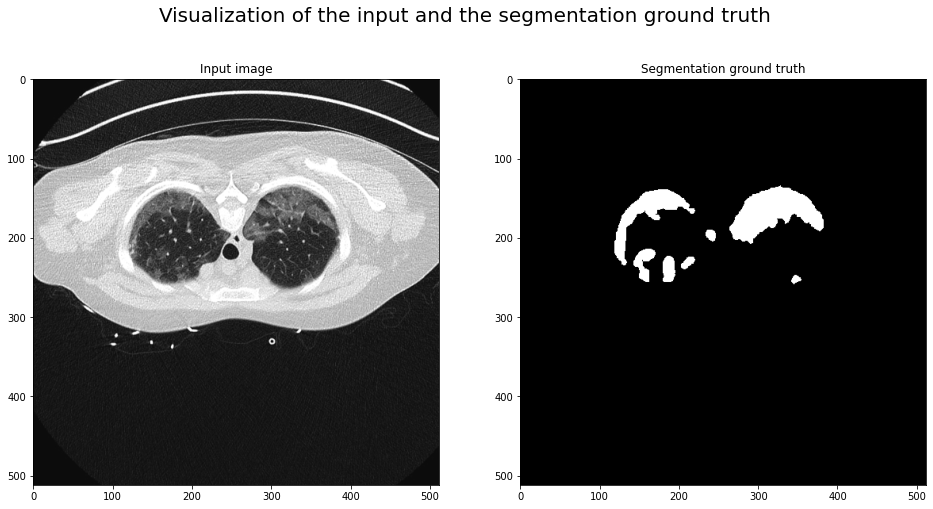

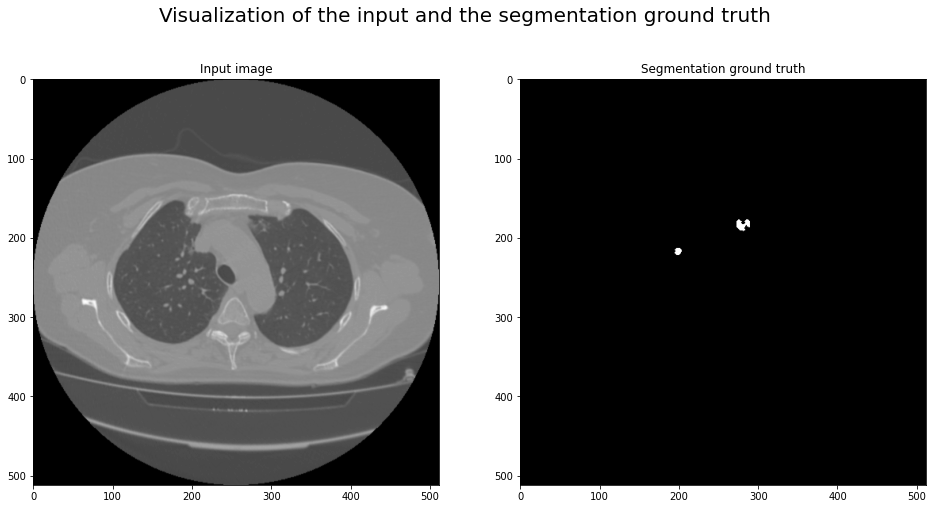

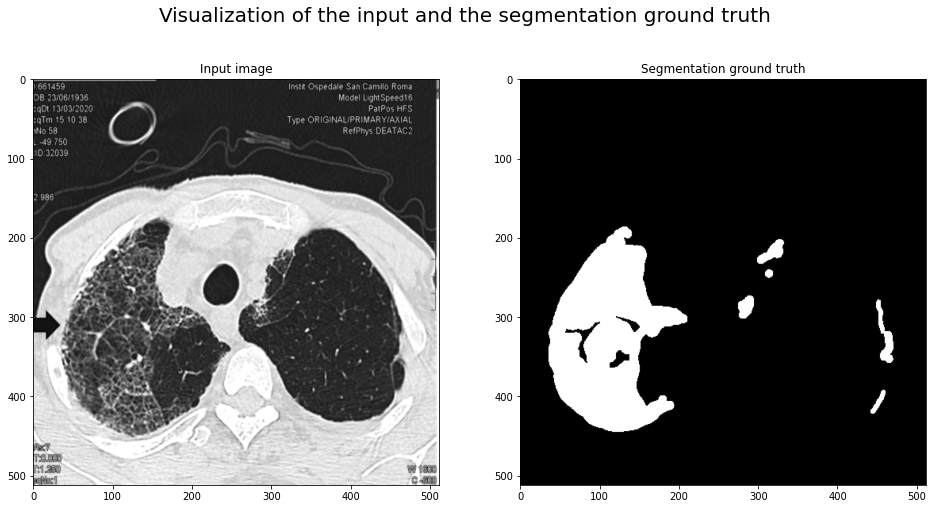

In [ ]:
for root, dirs, files in os.walk(os.path.join(path_drive, "data", "frames")):
  np.random.seed(1)
  l = np.random.randint(0,1000,3)
  for k in l:
    x = Image.open(os.path.join(path_drive, "data", "frames", files[k]))
    y = Image.open(os.path.join(path_drive, "data", "masks", files[k]))
    x_gray = x.convert('L')
    y_gray = y.convert('L')
    x_gray = transforms.functional.pil_to_tensor(x)
    y_gray = transforms.functional.pil_to_tensor(y)
    x_gray = transforms.ConvertImageDtype(torch.float32).forward(x_gray)
    y_gray = transforms.ConvertImageDtype(torch.float32).forward(y_gray)
    print(y_gray.dtype)
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(121)
    ax1.imshow(x_gray[0].numpy(), cmap='gray')
    ax1.set_title('Input image')
    ax2 = fig.add_subplot(122)
    ax2.imshow(y_gray[0].numpy(), cmap='gray')
    ax2.set_title('Segmentation ground truth')
    fig.suptitle('Visualization of the input and the segmentation ground truth', fontsize=20)

We want to keep only the cases due to corona virus so we will filter the files.

In [ ]:
list_of_files_in = []
list_of_files_out = []

for root, dirs, files in os.walk(os.path.join(path_drive, "data", "frames")):
  for file in files:
    if file.startswith('Jun_coronacases'):
      list_of_files_in.append(os.path.join(path_drive, "data", "frames", file))
      list_of_files_out.append(os.path.join(path_drive, "data", "masks", file))


In [ ]:
len(list_of_files_in)

1351

We have 1351 images and corresponding segmentations due to corona virus. 

Let's focus on these particular inputs and outputs.

torch.float32


Text(0.5, 0.98, 'Visualization of the input and the segmentation ground truth')

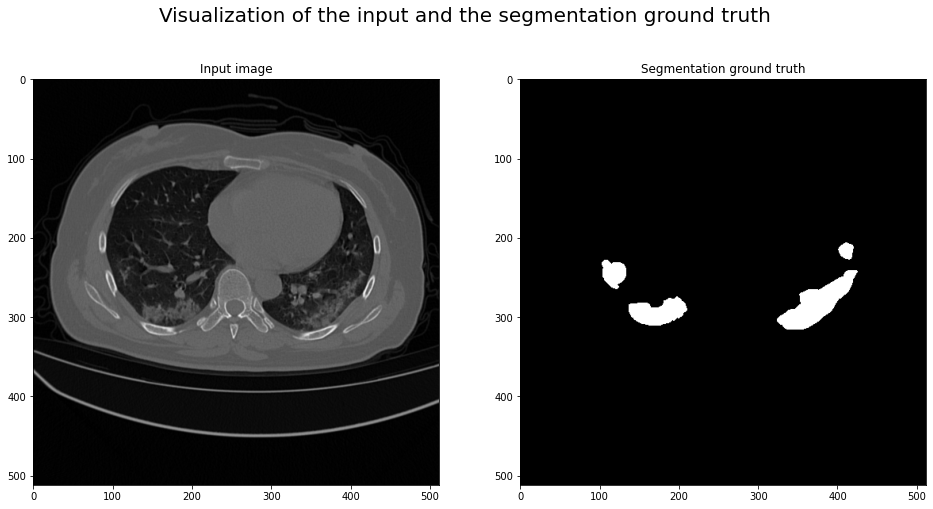

In [ ]:
index = 666


x = Image.open(list_of_files_in[index])
y = Image.open(list_of_files_out[index])
x_gray = x.convert('L')
y_gray = y.convert('L')
x_gray = transforms.functional.pil_to_tensor(x)
y_gray = transforms.functional.pil_to_tensor(y)
x_gray = transforms.ConvertImageDtype(torch.float32).forward(x_gray)
y_gray = transforms.ConvertImageDtype(torch.float32).forward(y_gray)
print(y_gray.dtype)
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121)
ax1.imshow(x_gray[0].numpy(), cmap='gray')
ax1.set_title('Input image')
ax2 = fig.add_subplot(122)
ax2.imshow(y_gray[0].numpy(), cmap='gray')
ax2.set_title('Segmentation ground truth')
fig.suptitle('Visualization of the input and the segmentation ground truth', fontsize=20)

Even without being a specialist, it is possible to see the lesions left by the corona virus. Unusual “white cloud” can be observed in some lungs. This cloud is actually tissue damaged by the disease responsible for severe respiratory disorders.

----

## 2. Creation of the dataset

Of course, we can't load all the images into memory. Our memory capacity is way too low. The solution is to build a home-made dataset which extends the Dataset class from torch.utils.data.

This dataset simply load input images and convert them into 1-channel-grayscale images. It returns the input image and the corresponding ground truth for "train" and "val" sets.

In [ ]:
class CoronaDataset(Dataset):

    def __init__(self, image_paths, seg_paths, split):
        
        # Define attributes
        self.image_paths = image_paths
        self.seg_paths = seg_paths
        self.split = split
        
        ################################################
        # Load images for 'train', 'val' and 'test' sets
        ################################################
        self.images = []
        for im_path in (self.image_paths):
            img = Image.open(im_path)
            img_gray = img.convert('L')
            img_gray = transforms.functional.pil_to_tensor(img_gray)
            img_gray = transforms.ConvertImageDtype(torch.float32).forward(img_gray)
            self.images.append(img_gray)

            text = ("Loaded images: " + str(len(self.images)) + ' / ' + str(len(self.image_paths)))
            sys.stdout.write('\r' + text)

        sys.stdout.write('\r') 
        print("Loaded images: " + str(len(self.images)) + ' / ' + str(len(self.image_paths)) + ' '*50)   
        ##############################################    
        # Load ground truth for 'train' and 'val' sets
        ##############################################

        if (self.split == 'train') or (self.split == 'val'):
          self.segs = []
          for seg_path in (self.seg_paths):
              seg = Image.open(seg_path)
              seg_gray = seg.convert('L')
              seg_gray = transforms.functional.pil_to_tensor(seg_gray)
              seg_gray = transforms.ConvertImageDtype(torch.float32).forward(seg_gray)
              self.segs.append(seg_gray)

              text = ("Loaded segmentations: " + str(len(self.segs)) + ' / ' + str(len(self.seg_paths)))
              sys.stdout.write('\r' + text)

        sys.stdout.write('\r') 
        print("Loaded segmentations: " + str(len(self.segs)) + ' / ' + str(len(self.seg_paths)) + ' '*50)   
        print('Succesfully loaded {} dataset.'.format(split) + ' '*50)
        
               
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        img = self.images[idx]

        #####################################################################
        # Return image and segmentation groundtruth for 'train' and 'val' set
        #####################################################################
        if (self.split == 'train') or (self.split == 'val'):
            seg = self.segs[idx]                                 
            return img, seg

        ##################################
        # Return only image for 'test' set
        ##################################
        else:
            return img
                                             
        


We divide the whole dataset into train and validation set.

In [ ]:
# split the dataset
train_input_path, val_input_path, train_output_path, val_output_path = sklearn.model_selection.train_test_split(list_of_files_in, 
                                                                                                                list_of_files_out, test_size=0.2, random_state=0)

In [ ]:
train_set = CoronaDataset(train_input_path, 
                          train_output_path,
                          split='train')

Loaded images: 1080 / 1080                                                  
Loaded segmentations: 1080 / 1080                                                  
Succesfully loaded train dataset.                                                  


In [ ]:
val_set = CoronaDataset(val_input_path, 
                        val_output_path,
                        split='val')

Loaded images: 271 / 271                                                  
Loaded segmentations: 271 / 271                                                  
Succesfully loaded val dataset.                                                  


The batch size can be changed. We choose a simple batch size of 1.

In [ ]:
batch_size = 1

For the data loader, the training samples have to be shuffled. This operation is not really necessary for the validation loader.

In [ ]:
train_loader = DataLoader(train_set, 
                          batch_size=batch_size, 
                          shuffle=True
                         )

val_loader = DataLoader(val_set, 
                        batch_size=batch_size, 
                        shuffle=False
                         )

torch.Size([1, 1, 512, 512])
torch.float32


Text(0.5, 0.98, 'Visualization of the input and the segmentation ground truth')

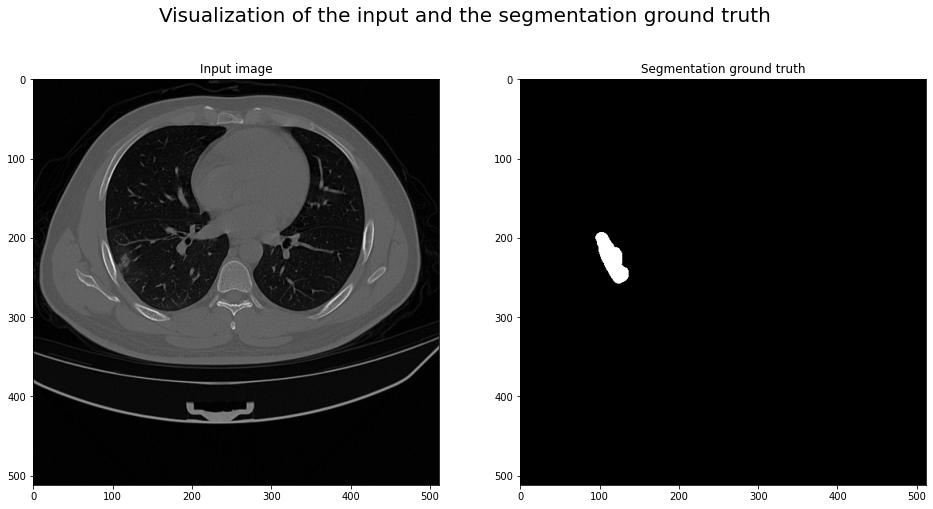

In [ ]:
train_data = iter(train_loader)
img, seg = train_data.next()

print(img.shape)
print(img.dtype)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121)
ax1.imshow(img[0][0].numpy(), cmap='gray')
ax1.set_title('Input image')
ax2 = fig.add_subplot(122)
ax2.imshow(seg[0][0].numpy(), cmap='gray')
ax2.set_title('Segmentation ground truth')
fig.suptitle('Visualization of the input and the segmentation ground truth', fontsize=20)

We can see that the images are perfectly loaded as expected.

----

## 3. Creation of the network

In order to complete this segmentation task, several networks were available. We have chosen to implement a U-net network, following the advice of Charles OLLION. 

There are several reasons for this choice:

- First, this network has the advantage of being theoretically quite simple. Indeed, the concepts behind the U-net are quite simple. The paper is relatively clear and allows easy handling of the network. [1] (https://arxiv.org/pdf/1505.04597.pdf)

- Secondly, this network has the advantage of being relatively inexpensive in terms of parameters. Indeed, this point is important because we work on Google Colab and our GPU resources are very limited.

- Finally, this network usually has good results on entries from medical imaging. While past performance may not always predict future performance, it was interesting to see the performance of the U-Net on this example.


Let's build this network.

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.epoch = 0

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.output_layer = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        out5 = self.up1(x5, x4)
        out4 = self.up2(out5, x3)
        out3 = self.up3(out4, x2)
        out2 = self.up4(out3, x1)
        out1 = self.output_layer(out2)
        out = torch.sigmoid(out1)

        return out

    
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Use the normal convolutions to reduce the number of channels
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    '''
    Simple convolution.
    '''
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


----

## 4. Creation of the metrics

In order to evaluate the performance of the network, we can compute some metrics. In addition to the loss, the Dice score and IoU metrics will be used to track the evolution of network performance across epochs.


In [ ]:
def compute_dice_coef(input, target):
    '''
    Compute dice score metric.
    '''
    batch_size = input.shape[0]
    return sum([dice_coef_sample(input[k,:,:], target[k,:,:]) for k in range(batch_size)])/batch_size

def dice_coef_sample(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return (2. * intersection) / (iflat.sum() + tflat.sum())


def compute_iou(input, target):
    '''
    Compute iou metric.
    '''
    batch_size = input.shape[0]
    return sum([iou_sample(input[k,:,:], target[k,:,:]) for k in range(batch_size)])/batch_size

def iou_sample(input, target):
    union = np.logical_or((input[0]>0.5).numpy(), target.numpy())*1
    intersection = np.logical_and((input[0]>0.5).numpy(), target.numpy())*1
    return np.sum(intersection)/np.sum(union)




----

## 5. Training 

For the training, we have chosen to use the BCE loss. Indeed, this loss can be used because our network gives us a value between 0 and 1 for each pixel of the output image. The ground truth is an image composed only of 0's and 1's.

For each pixel, the BCE is:

\begin{align}
BCE(pixel) & = -log(pixel)  \\
     & \text{if ground truth = 1 (injured area)}\\
BCE(pixel) & = -log(1-pixel)  \\
     & \text{if ground truth = 0 (normal area)}\\
\end{align}

The minimisation of the loss therefore pushes the pixels to be:
- if ground truth = 1 (injured area):
\begin{align}
BCE(pixel) ≃ 0 & ⇒ -log(pixel) ≃ 0  \\
& ⇒ pixel ≃ 1  \\
\end{align}

- if ground truth = 0 (normal area):
\begin{align}
BCE(pixel) ≃ 0 & ⇒ -log(1-pixel) ≃ 0  \\
& ⇒ 1-pixel ≃ 1  \\
& ⇒ pixel ≃ 0  \\
\end{align}

This is exactly what we want.

Moreover this loss is very optimized in torch and allows a training much faster than with dice score or iou. These metrics are suitable for measuring performance but not for training.

In [ ]:
device = torch.device("cuda:0")

# Network
modelUNet = UNet(n_channels=1, n_classes=1).to(device)

# Optimizer
optimizer = optim.Adam(modelUNet.parameters(), lr=1e-4, weight_decay=1e-12)

# Loss
seg_loss = torch.nn.BCELoss().to(device)

In [ ]:
total_epoch = 12

In [ ]:
do_train = False

In [ ]:
if do_train:
  # Define parameters
  nb_train_batches = len(train_loader)
  nb_val_batches = len(val_loader)

  list_loss_train = []
  list_dice_train = []
  list_iou_train = []

  list_loss_val = []
  list_dice_val = []
  list_iou_val = []


  while modelUNet.epoch < total_epoch:
      print('Epoch ' + str(modelUNet.epoch+1))
      ############
      # TRAINING #
      ############
      train_loss = 0
      train_dice_coef = 0
      train_iou = 0
      
      modelUNet.train()
      train_data = iter(train_loader)
      for k in range(nb_train_batches):
          # Loads data
          imgs, seg_gts = train_data.next()
          imgs, seg_gts = imgs.to(device), seg_gts.to(device)

          # Forward pass
          seg_pred = modelUNet(imgs)
          loss = seg_loss(seg_pred.double(), seg_gts.double())
  
          # Backward pass
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          with torch.no_grad():
              # Compute segmentation metric
              train_loss += loss/nb_train_batches
              
              dice_coef = compute_dice_coef(seg_pred, seg_gts)
              train_dice_coef += dice_coef.item()/nb_train_batches

              iou = compute_iou(seg_pred.cpu(), seg_gts.cpu())
              train_iou += iou.item()/nb_train_batches

          # Std out

          text = ('Training:  ' + ' iter ' + str(k+1) + '/' + str(nb_train_batches) + ', loss: ' + str(round(loss.item(),5)) )
          sys.stdout.write('\r' + text)

          
          # End of epoch

      ##############
      # VALIDATION #
      ##############
      val_loss = 0
      val_dice_coef = 0
      val_iou = 0

      modelUNet.eval()
      with torch.no_grad():
          val_data = iter(val_loader)
          for k in range(nb_val_batches):
              # Loads data
              imgs, seg_gts = val_data.next()
              imgs, seg_gts = imgs.to(device), seg_gts.to(device)

              # Forward pass
              seg_pred = modelUNet(imgs)
              loss = seg_loss(seg_pred.double(), seg_gts.double())
      
              
              # Compute segmentation metric
              val_loss += loss/nb_val_batches
              
              dice_coef = compute_dice_coef(seg_pred, seg_gts)
              val_dice_coef += dice_coef.item()/nb_val_batches

              iou = compute_iou(seg_pred.cpu(), seg_gts.cpu())
              val_iou += iou.item()/nb_val_batches


              text = ('Validation:  '  + ' iter ' + str(k+1) + '/' + str(nb_val_batches) + ', loss: ' + str(round(loss.item(),5)) )
              sys.stdout.write('\r' + text)

      
      
      list_loss_train.append(round(train_loss.item(),5))
      list_dice_train.append(round(train_dice_coef,5))
      list_iou_train.append(round(train_iou,5))

      list_loss_val.append(round(val_loss.item(),5))
      list_dice_val.append(round(val_dice_coef,5))
      list_iou_val.append(round(val_iou,5))

      sys.stdout.write('\r')
      print('Training :  loss {:.5f},  dice score :{},  iou :{}'.format(round(train_loss.item(),5), round(train_dice_coef,5), round(train_iou,5))  + ' '*20)
      print('Validation :  loss {:.5f},  dice score :{},  iou :{}'.format(round(val_loss.item(),5), round(val_dice_coef,5), round(val_iou,5))  + ' '*20)
      modelUNet.epoch += 1


In [ ]:
if do_train:
  torch.save(modelUNet.state_dict(), os.path.join(path_drive, "saved_unet512"))

In [ ]:
if not do_train:
  modelUNet.load_state_dict(torch.load(os.path.join(path_drive, "saved_unet512_b1")))

In [ ]:
if do_train:
  abscisse = np.arange(1, total_epoch+1)

  fig = plt.figure(figsize=(24,6))
  ax1 = fig.add_subplot(131)
  ax1.plot(abscisse, list_loss_train, label='Training')
  ax1.plot(abscisse, list_loss_val, label='Validation')
  ax1.set_title('Evolution of log-loss (BCE)')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('log loss')
  plt.yscale('log')
  ax1.legend()

  ax2 = fig.add_subplot(132)
  ax2.plot(abscisse, list_dice_train, label='Training')
  ax2.plot(abscisse, list_dice_val, label='Validation')
  ax2.set_ylim(0,1)
  ax2.set_title('Evolution of the Dice score')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('Dice score')
  ax2.legend()

  ax3 = fig.add_subplot(133)
  ax3.plot(abscisse, list_iou_train, label='Training')
  ax3.plot(abscisse, list_iou_val, label='Validation')
  ax3.set_ylim(0,1)
  ax3.set_title('Evolution of the IoU')
  ax3.set_xlabel('epoch')
  ax3.set_ylabel('IoU')
  ax3.legend()

You should obtain training and validation curves like that.

This our curves for a training on a 1-batch-training set and for 15 epochs.

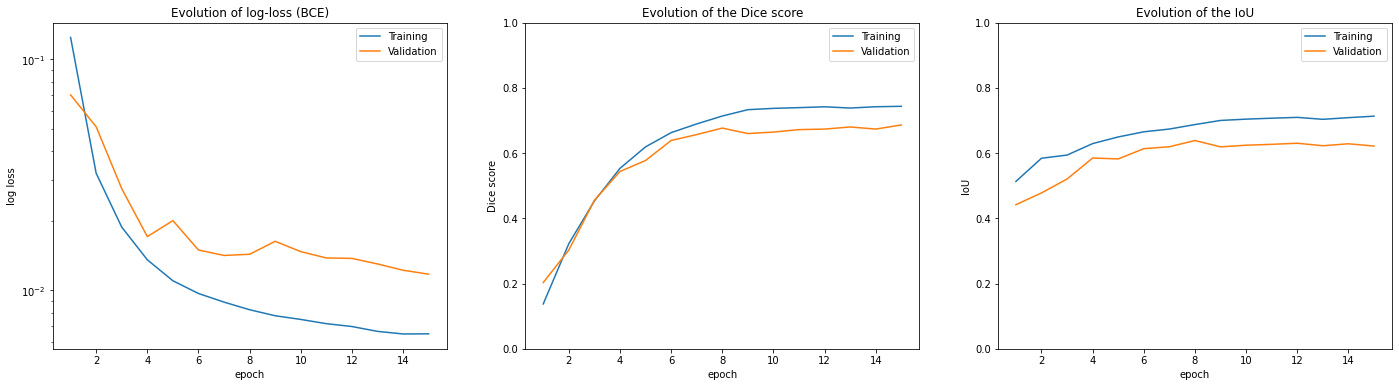

----

## 6. Visual assessment and conclusion

It is always difficult to set a threshold for which the Dice score or the IoU are acceptable. Visually, how much better is an IoU of 0.7 IoU over an IoU of 0.8 ? This question is difficult to answer.

To get a good idea of the network’s performance, we must not neglect the visual aspect. Indeed, image data often allows us to visually validate the results. We must as well use it!


In [ ]:
val_data = iter(val_loader)

In [ ]:
imgs, seg_gts = val_data.next()

In [ ]:
imgs_gpu = imgs.to(device)
with torch.no_grad():
  seg_pred_gpu = modelUNet(imgs_gpu)
seg_pred = seg_pred_gpu.cpu()

print(compute_iou(seg_pred, seg_gts))

0.7831188493565481


Text(0.5, 0.98, 'Visualization of the output')

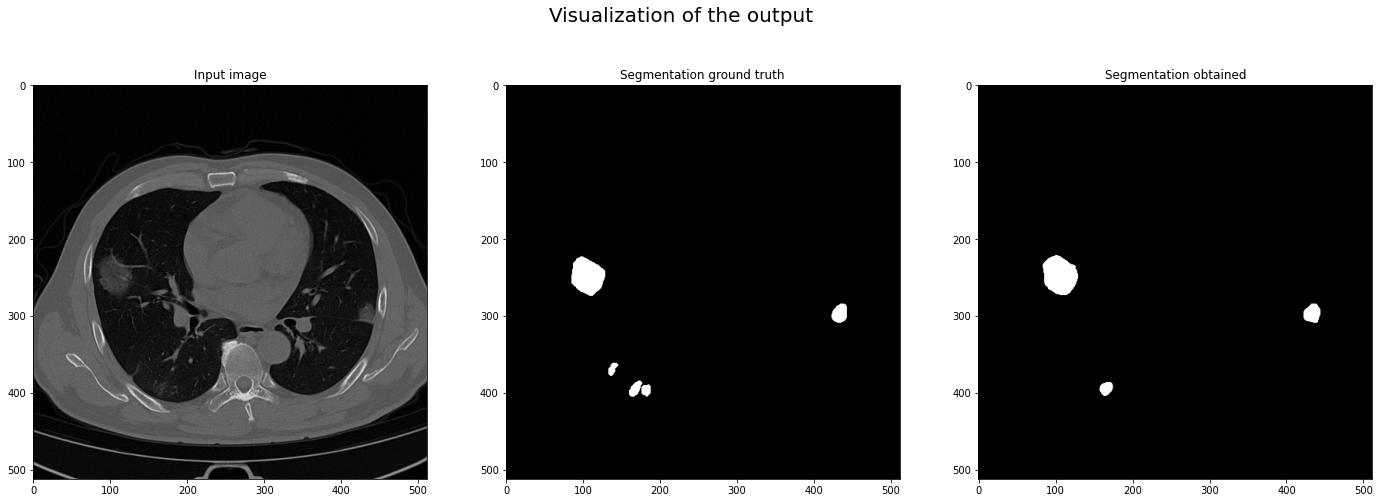

In [ ]:
fig = plt.figure(figsize=(24,8))
ax1 = fig.add_subplot(131)
ax1.imshow(imgs[0][0].detach().numpy(), cmap='gray')
ax1.set_title('Input image')
ax2 = fig.add_subplot(132)
ax2.imshow(seg_gts[0][0].numpy(), cmap='gray')
ax2.set_title('Segmentation ground truth')
ax3 = fig.add_subplot(133)
ax3.imshow((seg_pred[0][0]>0.3).detach().numpy(), cmap='gray')
ax3.set_title('Segmentation obtained')
fig.suptitle('Visualization of the output', fontsize=20)

Visually, we can clearly see that the segmentation is of good (or even very good) quality! The network perfectly identifies the affected areas. 
Of course, some defects are always visible.
- the contours of the areas are not exactly the same 
- some small lesions are not identified by the network
- some small lesions are wrongly added by the network

However, in general it can be said that our network largely fulfils the tasks asked of it. Indeed, like many medical software programs, our algorithm does not claim to be able to replace a doctor and have the same level of precision. Our algorithm can simply come upstream of the doctor’s diagnosis to facilitate and accelerate this task. 

The specifications are respected.


----